In [2]:
SS_MODEL = "ss/sentencespace"

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
from lib.utils import *
from repoman.filter_responses import get_repos_titles
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import OneClassSVM
from copy import deepcopy
import json

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Embedding

We need to embed the software in a metric space such that we can measure the similarity between one and another. We do this via the text description provided in the readme of the software's Github repositor.

First, we seek to learn a continuous representation of words such that documents can be represented, in the same metric space, as the normalized sum of their words. This is advantageous over techniques such as a word-count or tf-idf vector, as it allows us to learn similarities and complementarities in the use of words, and encode that in the embedding itself. This allows us to perform mathematical operations such as the canonical example: "King - Man = Queen," showing that not only have we learned the similarity between "King" and "Queen", which is useful, but we have also learned that their difference lies on a particular dimension, the dimension strongly represented in the word "Man."

This technique has become standard practise in natural-language processing, in fact, the first layer of any deep-learning language model can be seen as performing this same operation. When faced with unlabelled data, a technique known as word embedding is often used, where labels are "created" by assuming that words that appear in some relation to one another (close to one another, within the same sentance, within the same document) are indeed related. Popular word embedding techniques are Word2Vec, GloVe, and FastText. 

These popular techniques setup the problem such that they can learn, directly, the relationship of one word to another. While powerful, it is not always clear how to then turn these word embeddings into a document embeddings. One can average the vectors, or take a cleverly-weighted average of the vectors, which can work relatively well in practise, but there is no clear best approach.

StarSpace is a library and technique from Facebook's AI research team, published in 2017, that is uniquely built such that it optimizes the embedding of full sentences and documents directly as normalized sums of their component words. The end result is, like the other techniques, a dictionary of word embeddings (a fixed-width continuously-valued vector to represent each word). With StarSpace, however, the word embeddings are optimized explicitly to be summed together into "groups", such as sentences or documents, rather than intended to have meaning in-and-of themselves as word representations. The result is a document embeddings procedure that proves to be extremely accurate in comparing semantic textual similarity between sentences and documents. 

In our context, the algorithm works via the following steps: 

1. Picking a sentence in a repository. 
2. Picking the other sentences in the repository as the "positive labels"
3. Picking a handful of random sentences from _other_ repositories as the "negative labels"

We then learn a dictionary of word embeddings, $F$, such that the similarity measure is maximized between the chosen sentence and the positive labels, while minimized between the negative labels, when each sentence is represented as: 

$$
s = \frac{\sum_{i \in a} F_i}{ || \sum_{i \in a} F_i || }
$$

where $a$ contains the dictionary index of each word in the sentence. 

To show the power of this technique, we embed a few test words and a few test sentences and look at the heatmap of their distance in the embedded space: 

In [4]:
words = ['an accurate classification model', 'neural network', 'matlab', 'python', 'scala', 'java', 'javascript', 'html', 'bitcoin']
compare = embed_docs(SS_MODEL, '\n'.join(words))

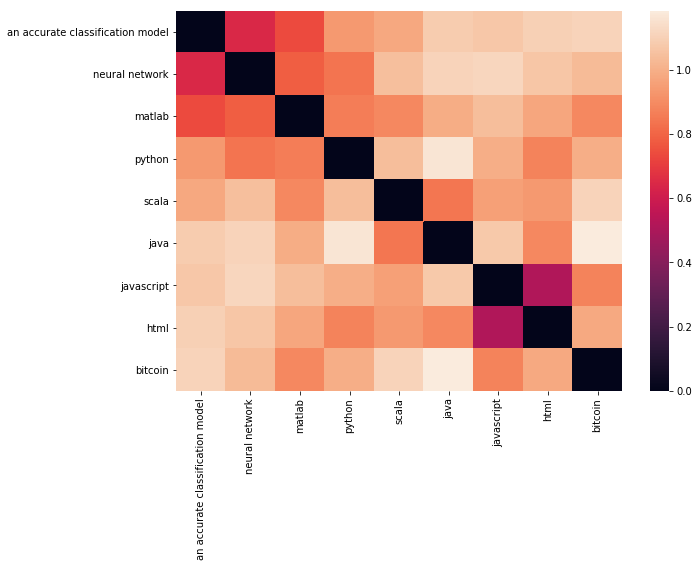

In [5]:
from scipy.spatial.distance import pdist,squareform

m = squareform(pdist(np.array(compare), 'cosine'))
_ = sns.heatmap(pd.DataFrame(m, columns = words, index= words))

Here we can see that a "neural network" and an "accurate classification model" are considered very close in the space. Similarly, "javascript" and "html" (programming languages that run together on web pages) are very close to one another. However, javascript and html are both very far from neural networks. This is exactly what we would expect, as, in the realm of programming, they have relatively little to do with one another, except when one might visualize neural networks on a webpage. 

In [6]:
with open('./ss/eye.txt', 'r') as f:
    foo = [l.strip().split(' ') for i,l in enumerate(f)]
    eyeball_tests = [' '.join(s) for s in foo]

v = embed_docs(SS_MODEL, '\n'.join(eyeball_tests))

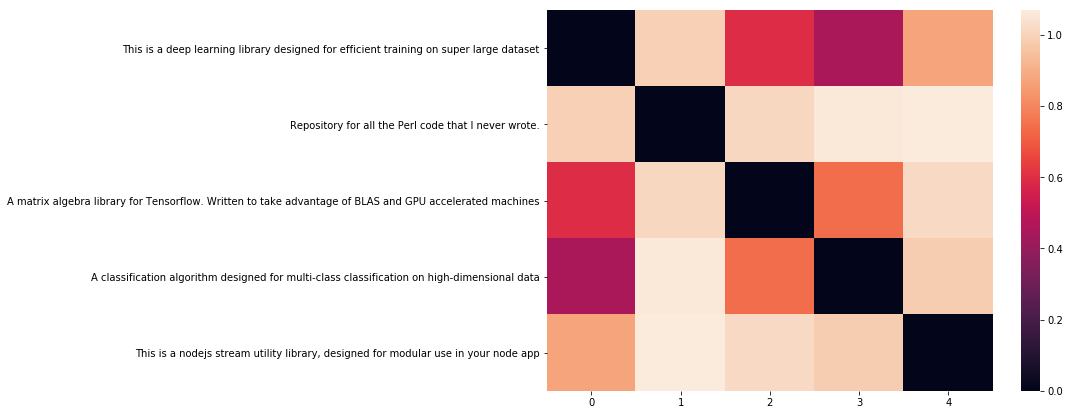

In [7]:
m = squareform(pdist(np.array(v), 'cosine'))
_ = sns.heatmap(pd.DataFrame(m, index= eyeball_tests))

This example shows that complex sentences that share no keywords whatsoever can still be accurately modeled in their distance to one another. Our embedding has learned the relationship of the concepts. It should be emphasized that if we were using a simple word-count or tf-idf vector to embed documents, all of these documents would be essentially unrelated. 

Using the embedding, however, we can see that software focused on matrix algebra and GPU's (row 3) is very close to a deep-learning library (row 1), which in turn is very close to software which runs a classification algorithm on high-dimensional data (row 4). None of these is particularly close to a "nodejs stream utility" (row 5), a library that is used in building servers to handle web requests.